# Gulf of Mexico Estuaries - Try the example workflow in other estuaries

## Standardize, clean and wrangle Water Quality Portal data in Gulf of Mexico Estuaries into more analytic-ready formats using the harmonize_wq package. 

This demo can be run one estuary at a time, or on all GOM estuaturies (SLOW!), but goes into less detail than the other demo notebooks.

Import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import os
import geopandas
import pandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
from harmonize_wq import location
from harmonize_wq import visualize
import dataretrieval.wqp as wqp

### Define Gulf of Mexico Estuaries

In [3]:
# Read geometry for Area of Interest from geojson file url
# NOTE: alternatively you can direct it to a local shapefile
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/new_release_0-3-8/harmonize_wq/tests/data/NCCA_dissolved_GOM.geojson'

<Axes: >

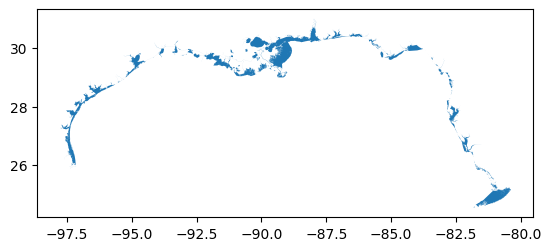

In [4]:
# Plot all the Gulf of Mexico Estuaries (geojson is WGS1984 standard)
wrangle.as_gdf(aoi_url).plot()

### Work through select estuary

In [5]:
aoi_gdf_all = wrangle.as_gdf(aoi_url)
aoi_gdf_all

,FID,EDACDA_NM,Shape_Leng,Shape_Area,geometry
0,0,_CDA_G045 (Big Cypre,2.459210e+05,4.845854e+07,"MULTIPOLYGON (((-81.78476 26.15005, -81.78529 ..."
1,1,_CDA_G053 (Charlotte,3.561144e+05,2.114096e+08,"MULTIPOLYGON (((-82.05840 26.46641, -82.05852 ..."
2,2,_CDA_G056 (Sarasota,1.732806e+05,2.514034e+07,"MULTIPOLYGON (((-82.25248 26.86147, -82.25213 ..."
3,3,_CDA_G074 (Crystal-P,1.709528e+06,3.854249e+08,"MULTIPOLYGON (((-82.73757 28.16579, -82.73827 ..."
4,4,_CDA_G078 (Waccasass,2.614051e+05,7.605671e+07,"MULTIPOLYGON (((-82.76983 29.08619, -82.77043 ..."
5,5,_CDA_G083 (Waccasass,2.257102e+05,7.069493e+07,"POLYGON ((-83.05707 29.20088, -83.05660 29.201..."
6,6,_CDA_G086 (Econfina-,1.298006e+05,2.603907e+07,"MULTIPOLYGON (((-83.31348 29.48099, -83.31419 ..."
7,7,_CDA_G095 (New),4.171870e+04,2.324903e+07,"POLYGON ((-84.44020 29.92805, -84.44102 29.928..."
8,8,_CDA_G108 (St. Andre,1.521129e+05,1.893677e+08,"MULTIPOLYGON (((-85.31034 29.83278, -85.30973 ..."
9,9,_CDA_G145 (Perdido B,3.018001e+04,1.046314e+07,"POLYGON ((-87.69336 30.25454, -87.69204 30.255..."


Choose an index for the estuary to retrieve

In [6]:
i = 25

In [7]:
# Print reformated estuary name
estuary_name = aoi_gdf_all.iloc[i]['EDACDA_NM']
out_est_name = str(estuary_name).replace(" ", "_")
out_est_name = out_est_name.replace(".", "")
out_est_name = out_est_name.replace("(", "")
out_est_name = out_est_name.replace(")", "")
print('Estuary Name: "{}" -> "{}"'.format(estuary_name, out_est_name))

Estuary Name: "Galveston Bay" -> "Galveston_Bay"


In [8]:
# Get polygon from polygons
aoi_gdf = aoi_gdf_all.iloc[i:i+1]

<Axes: >

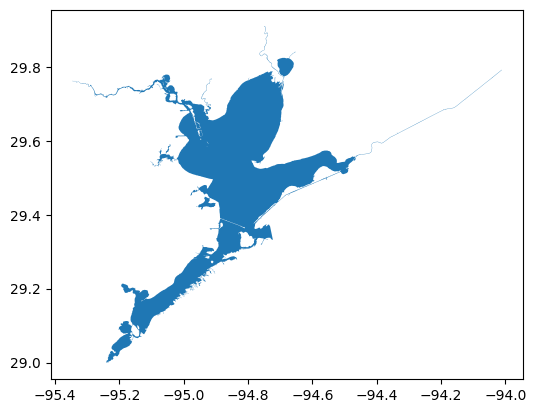

In [9]:
# Map selection
aoi_gdf.plot()

#### Build Query

In [10]:
# Each estuary may be multi-polygon, so the query will be built around the full extent instead of one row
bBox = wrangle.get_bounding_box(aoi_gdf)

In [11]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

#### Retrieve Data

In [12]:
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

# dataframe of downloaded results
res_narrow

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (4,5,9,10,15,17,19,22,31,33,34,36,38,61,62,63,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,2013-04-29,NaN,NaN,TCEQMAIN-15224,STORET-422578803,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,2013-07-11,NaN,NaN,TCEQMAIN-11446,STORET-422881708,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,2013-10-08,NaN,NaN,TCEQMAIN-15906,STORET-422797456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,2013-08-01,NaN,NaN,TCEQMAIN-11287,STORET-422829817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,2013-05-14,NaN,NaN,TCEQMAIN-15216,STORET-422577293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249329,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,CST,USGS-08042546,NWIS-126809215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
249330,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,CST,USGS-08042546,NWIS-126809227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
249331,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,CST,USGS-08042554,NWIS-126809095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
249332,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,CST,USGS-08042554,NWIS-126809105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

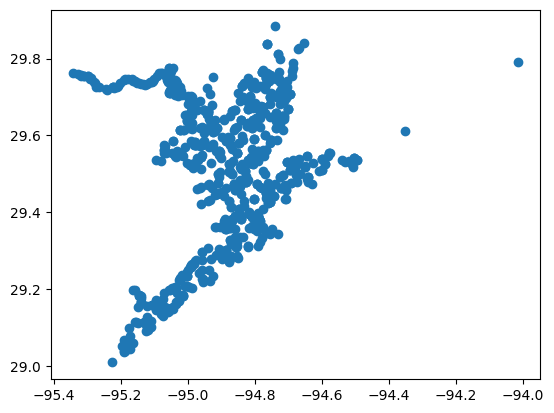

In [13]:
# Get harmonized stations clipped to the Area of Interest
stations_gdf, stations, site_md = location.get_harmonized_stations(query, aoi=aoi_gdf)
stations_gdf.plot()

#### Harmonize characteristic data (all at once)

The harmonize_all() function identifies the characteristics present and uses preset defaults to harmonize each. This function does not has as much flexibility e.g., to keep intermediate columns, produce reports, or convert to non-default units.

In [14]:
# Harmonize all results
df_harmonized = harmonize.harmonize_all(res_narrow, errors='ignore')
df_harmonized

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:329: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarnin

2 Phosphorus sample fractions not in frac_dict
2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'nu' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:329: UserWarning: WARNING: 'None' UNDEFINE

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,Carbon,Phosphorus,TP_Phosphorus,TDP_Phosphorus,Other_Phosphorus,Salinity,Sediment,Temperature,Turbidity,pH
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,2013-04-29,NaN,NaN,TCEQMAIN-15224,STORET-422578803,NaN,NaN,...,NaN,0.09 milligram / liter,NaN,NaN,0.09 milligram / liter,NaN,NaN,NaN,NaN,NaN
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,2013-07-11,NaN,NaN,TCEQMAIN-11446,STORET-422881708,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9 dimensionless
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,2013-10-08,NaN,NaN,TCEQMAIN-15906,STORET-422797456,NaN,NaN,...,NaN,0.24 milligram / liter,NaN,NaN,0.24 milligram / liter,NaN,NaN,NaN,NaN,NaN
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,2013-08-01,NaN,NaN,TCEQMAIN-11287,STORET-422829817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,2013-05-14,NaN,NaN,TCEQMAIN-15216,STORET-422577293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,28.2 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249329,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,CST,USGS-08042546,NWIS-126809215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6 dimensionless
249330,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,CST,USGS-08042546,NWIS-126809227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0 Nephelometric_Turbidity_Units,NaN
249331,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,CST,USGS-08042554,NWIS-126809095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0 degree_Celsius,NaN,NaN
249332,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,CST,USGS-08042554,NWIS-126809105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5 dimensionless


In [15]:
# Clean up other columns of data
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth
df_cleaned

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 217379 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,TP_Phosphorus,TDP_Phosphorus,Other_Phosphorus,Salinity,Sediment,Temperature,Turbidity,pH,Activity_datetime,Depth
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,2013-04-29,NaN,NaN,TCEQMAIN-15224,STORET-422578803,NaN,NaN,...,NaN,NaN,0.09 milligram / liter,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,2013-07-11,NaN,NaN,TCEQMAIN-11446,STORET-422881708,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9 dimensionless,NaT,NaN
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,2013-10-08,NaN,NaN,TCEQMAIN-15906,STORET-422797456,NaN,NaN,...,NaN,NaN,0.24 milligram / liter,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,2013-08-01,NaN,NaN,TCEQMAIN-11287,STORET-422829817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,2013-05-14,NaN,NaN,TCEQMAIN-15216,STORET-422577293,NaN,NaN,...,NaN,NaN,NaN,28.2 Practical_Salinity_Units,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249329,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,-0600,USGS-08042546,NWIS-126809215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6 dimensionless,2024-01-25 14:35:00+00:00,NaN
249330,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,-0600,USGS-08042546,NWIS-126809227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0 Nephelometric_Turbidity_Units,NaN,2024-01-25 14:35:00+00:00,NaN
249331,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,-0600,USGS-08042554,NWIS-126809095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.0 degree_Celsius,NaN,NaN,2024-01-25 18:35:00+00:00,NaN
249332,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,-0600,USGS-08042554,NWIS-126809105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5 dimensionless,2024-01-25 18:35:00+00:00,NaN


#### Map results

<Axes: >

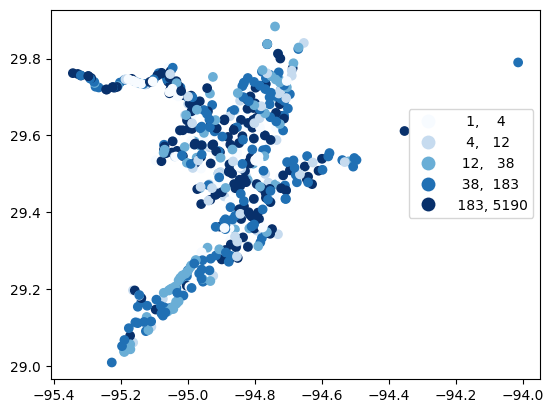

In [16]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_cleaned, stations_gdf)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

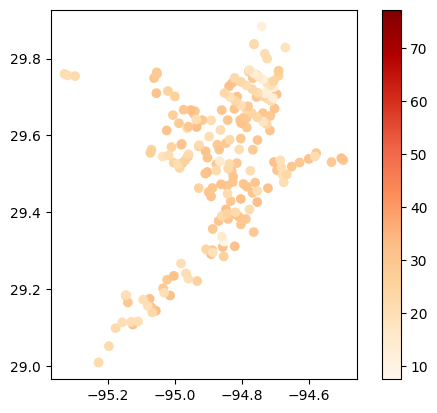

In [17]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_cleaned, stations_gdf, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Look through results one parameter at a time

In [18]:
# Set standard columns to look through results
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag']

Note: if there were no results for a given characteristic a result column will not be generated for that characteristic and there will be a keyError when trying to look at results, e.g., 'KeyError: "['Conductivity'] not in index"' if there are no conductivity results

In [19]:
# Secchi
df_cleaned.loc[df_cleaned['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Secchi
13,0.41,m,NaN,0.41 meter
25,0.91,m,NaN,0.91 meter
43,0.69,m,NaN,0.69 meter
51,0.20,m,NaN,0.2 meter
52,0.27,m,NaN,0.27 meter
...,...,...,...,...
249010,21.00,in,NaN,0.5334 meter
249019,0.41,m,NaN,0.41 meter
249023,0.20,m,NaN,0.2 meter
249025,0.28,m,NaN,0.28 meter


In [20]:
# Temperature
df_cleaned.loc[df_cleaned['CharacteristicName']=='Temperature, water', cols + ['Temperature']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature
11538,26.2,deg C,NaN,26.2 degree_Celsius
11887,25.8,deg C,NaN,25.8 degree_Celsius
11982,30.5,deg C,NaN,30.5 degree_Celsius
12056,26.0,deg C,NaN,26.0 degree_Celsius
12159,30.5,deg C,NaN,30.5 degree_Celsius
...,...,...,...,...
249319,16.7,deg C,NaN,16.7 degree_Celsius
249322,15.8,deg C,NaN,15.8 degree_Celsius
249325,16.1,deg C,NaN,16.1 degree_Celsius
249328,15.6,deg C,NaN,15.6 degree_Celsius


In [21]:
# Dissolved Oxygen
df_cleaned.loc[df_cleaned['CharacteristicName']=='Dissolved oxygen (DO)', cols + ['DO']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
11084,6.70,mg/L,NaN,6.7 milligram / liter
12779,1.70,mg/L,NaN,1.7 milligram / liter
14367,1.70,mg/L,NaN,1.7 milligram / liter
14585,2.10,mg/L,NaN,2.1 milligram / liter
14623,1.30,mg/L,NaN,1.3 milligram / liter
...,...,...,...,...
241652,6.60,mg/L,NaN,6.6 milligram / liter
241656,7.45,mg/L,NaN,7.45 milligram / liter
241689,8.70,mg/L,NaN,8.7 milligram / liter
241690,6.90,mg/L,NaN,6.9 milligram / liter


In [22]:
# pH
df_cleaned.loc[df_cleaned['CharacteristicName']=='pH', cols + ['pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
1,7.9,None,NaN,7.9 dimensionless
5,8.2,None,NaN,8.2 dimensionless
6,7.8,None,NaN,7.8 dimensionless
10,7.3,None,NaN,7.3 dimensionless
17,7.5,None,NaN,7.5 dimensionless
...,...,...,...,...
249320,6.7,std units,NaN,6.7 dimensionless
249323,6.8,std units,NaN,6.8 dimensionless
249326,6.7,std units,NaN,6.7 dimensionless
249329,6.6,std units,NaN,6.6 dimensionless


In [23]:
# Salinity
df_cleaned.loc[df_cleaned['CharacteristicName']=='Salinity', cols + ['Salinity']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
4,28.2,ppt,NaN,28.2 Practical_Salinity_Units
7,25.6,ppt,NaN,25.6 Practical_Salinity_Units
14,3.8,ppt,NaN,3.8 Practical_Salinity_Units
15,12.0,ppt,NaN,12.0 Practical_Salinity_Units
24,20.3,ppt,NaN,20.3 Practical_Salinity_Units
...,...,...,...,...
243312,18.8,ppt,NaN,18.8 Practical_Salinity_Units
243385,20.1,ppt,NaN,20.1 Practical_Salinity_Units
249022,10.9,ppt,NaN,10.9 Practical_Salinity_Units
249026,6.8,ppt,NaN,6.8 Practical_Salinity_Units


In [24]:
# Nitrogen
df_cleaned.loc[df_cleaned['CharacteristicName']=='Nitrogen', cols + ['Nitrogen']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
3,0.62,mg/L,NaN,0.62 milligram / liter
29,0.69,mg/L,NaN,0.69 milligram / liter
31,2.80,mg/L,NaN,2.8 milligram / liter
81,2.50,mg/L,NaN,2.5 milligram / liter
86,2.40,mg/L,NaN,2.4 milligram / liter
...,...,...,...,...
247796,1.29,mg/L,NaN,1.29 milligram / liter
247966,1.34,mg/L,NaN,1.34 milligram / liter
248200,1.23,mg/L,NaN,1.23 milligram / liter
248380,3.53,mg/L,NaN,3.53 milligram / liter


In [25]:
# Conductivity
if 'Conductivity' in df_cleaned.columns:
    df_cleaned.loc[df_cleaned['CharacteristicName']=='Conductivity', cols + ['Conductivity']]

In [26]:
# Chlorophyll A
df_cleaned.loc[df_cleaned['CharacteristicName']=='Chlorophyll a', cols + ['Chlorophyll']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
11,50.30,ug/L,NaN,0.0503 milligram / liter
18,16.30,ug/L,NaN,0.016300000000000002 milligram / liter
35,1.29,ug/L,NaN,0.0012900000000000001 milligram / liter
61,11.60,ug/L,NaN,0.0116 milligram / liter
73,20.20,ug/L,NaN,0.0202 milligram / liter
...,...,...,...,...
241681,3.72,ug/L,NaN,0.00372 milligram / liter
246877,1.00,ug/L,NaN,0.001 milligram / liter
247193,2.00,ug/L,NaN,0.002 milligram / liter
249104,10.80,ug/l,NaN,0.0108 milligram / liter


In [27]:
# Carbon
df_cleaned.loc[df_cleaned['CharacteristicName']=='Organic carbon', cols + ['Carbon']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
12,5.00,mg/L,NaN,5.0 milligram / liter
16,7.00,mg/L,NaN,7.0 milligram / liter
21,5.00,mg/L,NaN,5.0 milligram / liter
36,5.00,mg/L,NaN,5.0 milligram / liter
53,8.00,mg/L,NaN,8.0 milligram / liter
...,...,...,...,...
249183,6.16,mg/l,NaN,6.16 milligram / liter
249215,11.80,mg/l,NaN,11.8 milligram / liter
249216,7.05,mg/l,NaN,7.05 milligram / liter
249280,10.70,mg/l,NaN,10.7 milligram / liter


In [28]:
# Turbidity
df_cleaned.loc[df_cleaned['CharacteristicName']=='Turbidity', cols + ['Turbidity']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
302,28.0,NTU,NaN,28.0 Nephelometric_Turbidity_Units
370,3.0,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,3.0 Nephelometric_Turbidity_Units
565,3.0,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,3.0 Nephelometric_Turbidity_Units
588,2.0,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,2.0 Nephelometric_Turbidity_Units
686,2.0,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,2.0 Nephelometric_Turbidity_Units
...,...,...,...,...
249321,35.0,FNU,NaN,35.0 Nephelometric_Turbidity_Units
249324,150.0,FNU,NaN,150.0 Nephelometric_Turbidity_Units
249327,56.0,FNU,NaN,56.0 Nephelometric_Turbidity_Units
249330,57.0,FNU,NaN,57.0 Nephelometric_Turbidity_Units


In [29]:
# Sediment
df_cleaned.loc[df_cleaned['CharacteristicName']=='Sediment', cols + ['Sediment']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
221899,0.0091,g,NaN,NaN
221900,0.0091,g,NaN,NaN
221901,0.0000,g,NaN,NaN
221921,0.0140,g,NaN,NaN
221922,0.0136,g,NaN,NaN
...,...,...,...,...
249294,0.1214,g,NaN,NaN
249295,0.0116,g,NaN,NaN
249296,0.1478,g,NaN,NaN
249297,0.1410,g,NaN,NaN


In [30]:
# Phosphorus
df_cleaned.loc[df_cleaned['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
201017,0.060,mg/l as P,NaN,0.06 milligram / liter
201093,0.020,mg/l as P,NaN,0.02 milligram / liter
201142,0.070,mg/l as P,NaN,0.07 milligram / liter
201353,0.020,mg/l as P,NaN,0.02 milligram / liter
201426,0.030,mg/l as P,NaN,0.03 milligram / liter
...,...,...,...,...
249121,0.096,mg/l as P,NaN,0.096 milligram / liter
249135,0.070,mg/l as P,NaN,0.07 milligram / liter
249141,0.050,mg/l as P,NaN,0.05 milligram / liter
249147,0.090,mg/l as P,NaN,0.09 milligram / liter


In [31]:
df_cleaned.loc[df_cleaned['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TP_Phosphorus
309,0.16,mg/L,NaN,0.16 milligram / liter
587,0.08,mg/L,NaN,0.08 milligram / liter
693,0.81,mg/L,NaN,0.81 milligram / liter
767,0.18,mg/L,NaN,0.18 milligram / liter
1074,0.33,mg/L,NaN,0.33 milligram / liter
...,...,...,...,...
249163,0.11,mg/l as P,NaN,0.11 milligram / liter
249175,0.18,mg/l as P,NaN,0.18 milligram / liter
249181,0.30,mg/l as P,NaN,0.3 milligram / liter
249214,0.22,mg/l as P,NaN,0.22 milligram / liter


### Characteristic to Column (long to wide format)

Note: each parameter should be compared against acceptance criteria before these steps as duplicates and bad data can be problematic

In [32]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df_cleaned)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Turbidity,QA_Chlorophyll,QA_Nitrogen,QA_DO,QA_Sediment,QA_Conductivity,QA_Secchi,QA_Temperature,QA_pH,QA_Carbon
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,2013-04-29,NaN,NaN,TCEQMAIN-15224,STORET-422578803,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,2013-07-11,NaN,NaN,TCEQMAIN-11446,STORET-422881708,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,2013-10-08,NaN,NaN,TCEQMAIN-15906,STORET-422797456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,2013-08-01,NaN,NaN,TCEQMAIN-11287,STORET-422829817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,2013-05-14,NaN,NaN,TCEQMAIN-15216,STORET-422577293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249329,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,-0600,USGS-08042546,NWIS-126809215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249330,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400657,2024-01-25,08:35:00,-0600,USGS-08042546,NWIS-126809227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249331,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,-0600,USGS-08042554,NWIS-126809095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249332,USGS-TX,USGS Texas Water Science Center,nwistx.01.02400659,2024-01-25,12:35:00,-0600,USGS-08042554,NWIS-126809105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df_cleaned.columns)))

15 new columns


In [34]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df_cleaned)-len(df2)))

18277 fewer rows


In [35]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [36]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [37]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Chlorophyll', 'Conductivity', 'Secchi', 'DO', 'E_coli',
       'Fecal_Coliform', 'Nitrogen', 'Speciation',
       'TOTAL NITROGEN_ MIXED FORMS', 'Carbon', 'Phosphorus', 'TP_Phosphorus',
       'TDP_Phosphorus', 'Other_Phosphorus', 'Salinity', 'Sediment',
       'Temperature', 'Turbidity', 'pH', 'Activity_datetime', 'Depth',
       'QA_E_coli', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus', 'QA_Salinity', 'QA_Fecal_Coliform',
       'QA_Turbidity', 'QA_Chlorophyll', 'QA_Nitrogen', 'QA_DO', 'QA_Sediment',
       'QA_Conductivity', 'QA_Secchi', 'QA_Temperature', 'QA_pH', 'QA_Carbon'],
      dtype='object')

In [38]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Chlorophyll,Conductivity,Secchi,DO,E_coli,...,QA_Turbidity,QA_Chlorophyll,QA_Nitrogen,QA_DO,QA_Sediment,QA_Conductivity,QA_Secchi,QA_Temperature,QA_pH,QA_Carbon
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,TCEQMAIN-15224,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,TCEQMAIN-11446,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,TCEQMAIN-15906,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,TCEQMAIN-11287,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,TCEQMAIN-15216,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Salinity',
 'QA_Nitrogen',
 'QA_DO',
 'QA_Sediment',
 'QA_Conductivity',
 'QA_Secchi',
 'QA_Temperature',
 'QA_pH',
 'QA_Carbon']

<Axes: >

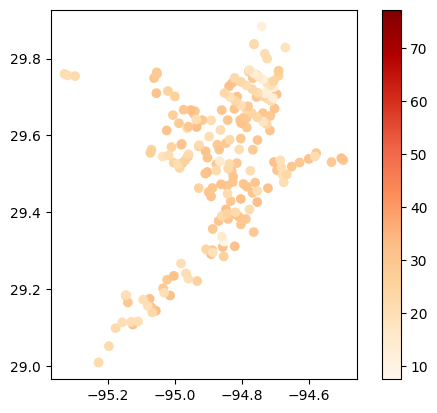

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_gdf, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)